XGBoost to predict streamflow. Forcings are aggregated from hourly to daily to match streamflow resolution.

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn import metrics
from datetime import datetime, timedelta
import hydroeval
import netCDF4 as nc
import xgboost as xgb
import scipy as sp
from src import load_data, evaluate

np.random.seed(0)

time_stamp = datetime.now().strftime('%Y%m%d-%H%M%S')
time_stamp

'20190706-115444'

In [2]:
station_data_dict = load_data.load_train_test_gridded_aggregatedForcings(include_all_forcing_vars=True)

In [3]:
param_dist = {
    'max_depth': sp.stats.randint(1, 8),
    'learning_rate': sp.stats.uniform(0.0005, 0.5),
    'gamma': sp.stats.uniform(0, 1),
    'min_child_weight': sp.stats.randint(1, 15),
    'subsample': sp.stats.uniform(0.7, 0.3),
    'colsample_bytree': sp.stats.uniform(0.4, 0.6),
    'colsample_bylevel': sp.stats.uniform(0.4, 0.6),
    'reg_alpha': sp.stats.expon(0, 20),
    'reg_lambda': sp.stats.expon(0, 20),
}

In [4]:
# Create test and train splits for each station (by time), then create predictions for each subbasin
history = 7
train_start = datetime.strptime('2010-01-01', '%Y-%m-%d') + timedelta(days=history + 1)
train_end = '2012-12-31'
test_start = datetime.strptime(train_end, '%Y-%m-%d') + timedelta(days=1)
test_end = '2014-12-31'

validation_fraction = 0.1

predictions = {}
actuals = {}
models = {}
for station in station_data_dict.keys():
    print(station)
    station_data = station_data_dict[station]
    
    station_train = station_data.loc[train_start : train_end].copy()
    num_validation_samples = int(validation_fraction * station_train.shape[0])
    shuffle_indices = np.arange(station_train.shape[0])
    np.random.shuffle(shuffle_indices)
    station_train = station_train.iloc[shuffle_indices]
    station_val, station_train = station_train.iloc[:num_validation_samples].copy(), station_train.iloc[num_validation_samples:].copy()
    
    station_test = station_data.loc[test_start : test_end]
    print('Shapes: train {}, val {}, test {}'.format(station_train.shape, station_val.shape, station_test.shape))

    station_val = [(station_train.drop(['station', 'runoff'], axis=1), station_train['runoff']), 
                   (station_val.drop(['station', 'runoff'], axis=1), station_val['runoff'])]
    
    xgb_model = xgb.XGBRegressor(n_estimators=1000, n_jobs=-1, random_state=123)
    m = model_selection.RandomizedSearchCV(xgb_model, param_dist, n_iter=1000, cv=3, return_train_score=True, scoring='neg_mean_squared_error', n_jobs=-1, random_state=123, verbose=5)
    m.fit(station_train.drop(['station', 'runoff'], axis=1), station_train['runoff'], eval_set=station_val, eval_metric='rmse', early_stopping_rounds=100, verbose=False)
    
    cv_results = pd.DataFrame(m.cv_results_).sort_values(by='mean_test_score', ascending=False)
    print(cv_results.filter(regex='param_|mean_test_score|mean_train_score', axis=1).head())
    print('Best params: {}'.format(m.best_params_))
    print(cv_results.loc[m.best_index_, ['mean_train_score', 'mean_test_score']])
    
    station_test = station_test[~pd.isna(station_test['runoff'])]
    if len(station_test) == 0:
        print('Skipping', station)
        continue

    predict = pd.DataFrame(index=station_test.index)
    predict = predict.join(station_test.drop(['station', 'runoff'], axis=1))
    predict['runoff'] = np.nan
    predict['runoff'] = m.predict(predict.drop('runoff', axis=1))

    predictions[station] = predict[['runoff']]
    actuals[station] = station_test['runoff']
    models[station] = m

02GA010
Shapes: train (980, 1646), val (108, 1646), test (730, 1646)
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 16.6min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
280                0.672979               0.456649    0.864732   
789                0.794009                0.43728    0.399781   
358                 0.95086               0.786686    0.752434   
552                0.402035               0.860439  0.00323348   
416                0.792472               0.614149    0.843413   

    param_learning_rate param_max_depth param_min_child_weight  \
280           0.0469065               5                     11   
789           0.0486125               3                     12   
358            0.284412               3                      9   
552            0.124633               7                     13   
416           0.0288661               3                      4   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
280         3.81508          15.0856         0.81862      -139.710297   
789          8.6281          29.4711        0.825414      -1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  8.5min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
90                 0.927685               0.502277    0.559455   
94                 0.523503               0.790026    0.936472   
828                0.550193               0.471905   0.0325992   
488                0.591593               0.519173    0.796693   
428                0.935736               0.856755   0.0278664   

    param_learning_rate param_max_depth param_min_child_weight  \
90             0.197841               4                     12   
94              0.11229               3                      5   
828             0.28422               3                     14   
488            0.177023               3                      3   
428           0.0792075               4                     14   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
90          66.5009         0.863769        0.704253       -81.658382   
94          38.1864          35.1651        0.805511       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  8.2min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
885                0.782305               0.668232    0.542427   
72                 0.875591               0.545777    0.465148   
58                 0.609711               0.566454    0.998918   
828                0.550193               0.471905   0.0325992   
214                0.507133               0.650913    0.970351   

    param_learning_rate param_max_depth param_min_child_weight  \
885            0.165905               6                      9   
72             0.217993               5                     14   
58            0.0208081               3                     13   
828             0.28422               3                     14   
214            0.212256               5                     14   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
885         29.9006          7.00102        0.705378       -52.126078   
72          2.59852          14.9188        0.833875       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   54.2s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 10.7min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
650                0.642457               0.855554    0.667817   
346                0.949186               0.596089    0.195221   
150                0.695268               0.679011    0.314722   
310                0.799956               0.517198    0.174419   
522                 0.92684               0.783719     0.77108   

    param_learning_rate param_max_depth param_min_child_weight  \
650           0.0709069               2                      6   
346            0.157031               2                     14   
150            0.168336               3                      6   
310            0.140612               3                      2   
522            0.158659               3                      8   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
650         15.2017          8.02298        0.830693       -29.546306   
346         15.7567            17.87        0.878116       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed: 16.4min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed: 22.7min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed: 30.0min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed: 36.7min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed: 44.5min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed: 52.9min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 68.8min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
463                0.534683               0.741569    0.575773   
474                 0.69314               0.405035    0.178761   
879                0.559733               0.958071    0.511007   
628                 0.97009               0.982672      0.4955   
261                0.747597               0.810764    0.976776   

    param_learning_rate param_max_depth param_min_child_weight  \
463           0.0240105               2                     12   
474           0.0650908               3                     13   
879           0.0871464               4                      1   
628           0.0638778               2                      3   
261           0.0438398               3                      5   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
463         1.04628          16.4727        0.713125     -2003.235050   
474         25.6718          11.9191        0.802366     -20

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   56.1s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  9.8min

    param_colsample_bylevel param_colsample_bytree param_gamma  \
631                0.770465               0.560365    0.557289   
650                0.642457               0.855554    0.667817   
751                0.490458               0.755026    0.342998   
319                0.961858               0.627774    0.744055   
250                 0.40779               0.816308    0.988558   

    param_learning_rate param_max_depth param_min_child_weight  \
631            0.145192               2                      2   
650           0.0709069               2                      6   
751            0.189597               2                      1   
319            0.135074               2                     14   
250           0.0438701               2                      7   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
631         10.6614          7.99432        0.759741       -14.930425   
650         15.2017          8.02298        0.830693       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  7.3min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
131                0.428328               0.993884    0.787217   
232                0.835762               0.727974    0.695974   
53                 0.434562               0.631493    0.733229   
987                0.793514               0.442753     0.39974   
599                0.590108               0.482561    0.727483   

    param_learning_rate param_max_depth param_min_child_weight  \
131            0.220404               2                      5   
232            0.145673               3                      5   
53            0.0684254               2                      1   
987            0.454185               2                      4   
599            0.186851               6                      9   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
131         7.06824          11.4885        0.955236       -63.232019   
232         45.1919          8.02157        0.970885       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 16.5min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
160                0.533074               0.506938    0.463975   
644                0.464959               0.473527    0.225539   
213                 0.88196               0.863367    0.147996   
408                0.994688               0.714771    0.596268   
83                 0.825442               0.514338    0.306369   

    param_learning_rate param_max_depth param_min_child_weight  \
160            0.146983               2                      1   
644           0.0970254               3                      4   
213           0.0461555               4                      7   
408           0.0354255               4                     12   
83             0.171035               4                      9   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
160         37.5946          71.2657        0.749302       -12.384883   
644         12.2887          72.5826        0.952129       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   59.5s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 10.9min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
650                0.642457               0.855554    0.667817   
552                0.402035               0.860439  0.00323348   
606                0.503448               0.910412    0.738199   
28                 0.589086               0.694906    0.820142   
631                0.770465               0.560365    0.557289   

    param_learning_rate param_max_depth param_min_child_weight  \
650           0.0709069               2                      6   
552            0.124633               7                     13   
606            0.220716               2                      9   
28            0.0668102               5                     10   
631            0.145192               2                      2   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
650         15.2017          8.02298        0.830693       -15.750452   
552         2.18236           17.748        0.717037       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 13.4min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
595                0.479489               0.492719    0.364028   
992                0.911163               0.610604     0.53926   
480                0.510841               0.858786    0.700754   
210                0.464325               0.791638    0.672919   
602                0.696491               0.410349    0.555523   

    param_learning_rate param_max_depth param_min_child_weight  \
595           0.0468124               2                      1   
992           0.0176548               7                      3   
480           0.0644897               6                      1   
210            0.162053               2                      3   
602            0.440254               5                     10   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
595         2.16514         0.317428        0.818003       -35.637120   
992         2.88438          2.65157        0.792856       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 16.7min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
257                0.580552               0.410397   0.0209257   
204                0.695613               0.497658     0.86181   
943                0.513192               0.890407    0.761436   
544                0.738344                0.75687    0.310562   
231                0.454581               0.610957    0.525642   

    param_learning_rate param_max_depth param_min_child_weight  \
257            0.264919               2                      4   
204           0.0854604               3                     14   
943            0.176006               3                      4   
544           0.0448832               2                      6   
231            0.122587               6                     13   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
257         20.8352          7.77647         0.79908       -49.484673   
204          4.5028          15.3554        0.964252       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  9.4min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
128                0.584352               0.801665    0.294294   
955                0.428398               0.557488    0.566875   
474                 0.69314               0.405035    0.178761   
679                0.574764                0.68462    0.849544   
982                0.993627               0.564334    0.482557   

    param_learning_rate param_max_depth param_min_child_weight  \
128            0.451586               3                      4   
955            0.222212               2                      1   
474           0.0650908               3                     13   
679            0.228244               2                      3   
982            0.338841               6                     14   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
128         1.47712          3.25985        0.909418       -20.809657   
955         28.7274           18.556        0.792979       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  8.1min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
145                0.460033               0.402031    0.285074   
851                0.561997               0.531294    0.291149   
828                0.550193               0.471905   0.0325992   
66                 0.418546               0.431401    0.112933   
840                0.675297               0.708511    0.167835   

    param_learning_rate param_max_depth param_min_child_weight  \
145           0.0826034               5                     11   
851            0.213659               4                     11   
828             0.28422               3                     14   
66             0.374177               4                      9   
840            0.120444               5                     12   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
145         8.75869          34.9643        0.791098       -14.843082   
851         26.8121          32.8397        0.712668       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 14.6min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
349                0.700763               0.796831     0.56879   
660                0.774493               0.405713   0.0949222   
722                0.826183               0.523814     0.80899   
570                0.467012               0.620824    0.883099   
549                0.982989               0.420292   0.0618481   

    param_learning_rate param_max_depth param_min_child_weight  \
349           0.0529696               5                     12   
660            0.100846               5                     12   
722           0.0962687               5                     11   
570           0.0820456               6                      8   
549           0.0585903               5                     13   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
349         31.1175         0.599391         0.83767       -84.421296   
660         10.0827          1.32193        0.902242       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 17.7min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
900                0.663963               0.552722    0.180675   
474                 0.69314               0.405035    0.178761   
557                0.969038               0.655816   0.0963781   
7                  0.813563               0.921622    0.267804   
645                0.501446               0.933008    0.887647   

    param_learning_rate param_max_depth param_min_child_weight  \
900           0.0343671               3                     14   
474           0.0650908               3                     13   
557            0.108288               3                     12   
7              0.228874               3                      4   
645           0.0801224               3                     14   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
900         19.9543          29.3762        0.925205      -254.699097   
474         25.6718          11.9191        0.802366      -2

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 12.2min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
24                 0.755435               0.679914     0.67366   
877                0.920583               0.934773    0.718356   
80                 0.971562               0.885176    0.164779   
207                0.552134               0.724503    0.127207   
756                0.690181               0.575484    0.164062   

    param_learning_rate param_max_depth param_min_child_weight  \
24              0.19624               6                      7   
877            0.293122               3                     10   
80             0.104025               7                      6   
207           0.0822749               5                      5   
756            0.127725               3                      9   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
24          67.4508          1.89742        0.717438       -37.747680   
877         30.4177          34.0253        0.780944       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 14.9min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
37                 0.723671                0.44826    0.566347   
640                0.872784               0.698228     0.61908   
322                 0.54595               0.727617   0.0516954   
628                 0.97009               0.982672      0.4955   
276                0.520426               0.678473     0.78045   

    param_learning_rate param_max_depth param_min_child_weight  \
37             0.181742               2                     12   
640            0.136549               2                     14   
322            0.137391               2                      7   
628           0.0638778               2                      3   
276            0.214404               2                     10   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
37          21.1988          8.76709        0.914577      -102.963166   
640         36.4714          4.70614        0.913387      -1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   49.6s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  9.6min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
474                 0.69314               0.405035    0.178761   
506                0.683316               0.418606    0.394461   
833                0.862273                0.79119    0.855825   
837                0.604087               0.671023    0.794856   
379                0.661732               0.733749    0.776195   

    param_learning_rate param_max_depth param_min_child_weight  \
474           0.0650908               3                     13   
506            0.154516               4                      9   
833            0.173713               5                     14   
837           0.0247538               5                     11   
379            0.102369               4                     11   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
474         25.6718          11.9191        0.802366       -23.741078   
506         27.1632          8.01954        0.787215       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 17.6min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
564                0.445087               0.698789    0.399486   
153                0.939975               0.825785    0.528818   
188                0.519597               0.562186    0.897303   
29                 0.645634               0.623512     0.33997   
480                0.510841               0.858786    0.700754   

    param_learning_rate param_max_depth param_min_child_weight  \
564            0.133108               5                      4   
153           0.0275494               6                      2   
188           0.0551259               4                      3   
29             0.406785               4                      2   
480           0.0644897               6                      1   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
564         20.9824          1.44855        0.785521      -157.656868   
153         9.56207           3.7639        0.746856      -1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   53.3s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 10.1min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
999                0.917596               0.575961    0.382414   
211                0.751507               0.908091    0.939502   
210                0.464325               0.791638    0.672919   
258                0.858813               0.861561    0.921226   
416                0.792472               0.614149    0.843413   

    param_learning_rate param_max_depth param_min_child_weight  \
999            0.138932               4                      6   
211          0.00983328               4                      9   
210            0.162053               2                      3   
258            0.168927               3                      6   
416           0.0288661               3                      4   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
999         5.47995         0.280702        0.903819       -13.954405   
211         8.19451          2.36558         0.79782       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   49.3s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  9.3min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
751                0.490458               0.755026    0.342998   
992                0.911163               0.610604     0.53926   
769                 0.59907               0.865546    0.732138   
595                0.479489               0.492719    0.364028   
219                0.487571               0.711936    0.731344   

    param_learning_rate param_max_depth param_min_child_weight  \
751            0.189597               2                      1   
992           0.0176548               7                      3   
769           0.0483023               6                      1   
595           0.0468124               2                      1   
219            0.158015               3                      3   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
751         23.8685          3.88007        0.765922       -14.275365   
992         2.88438          2.65157        0.792856       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 13.2min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
595                0.479489               0.492719    0.364028   
521                0.901039               0.835501    0.324206   
985                0.538815               0.692219   0.0712341   
593                0.415917                0.62334    0.565436   
953                0.947967               0.464503     0.35843   

    param_learning_rate param_max_depth param_min_child_weight  \
595           0.0468124               2                      1   
521            0.437903               1                      1   
985           0.0758789               1                      7   
593            0.167012               1                      1   
953            0.192378               1                      1   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
595         2.16514         0.317428        0.818003       -15.086543   
521         8.01245          3.21553        0.931682       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   40.8s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 19.1min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
595                0.479489               0.492719    0.364028   
249                0.555175                0.68515     0.23536   
769                 0.59907               0.865546    0.732138   
210                0.464325               0.791638    0.672919   
327                0.747414               0.887742    0.150078   

    param_learning_rate param_max_depth param_min_child_weight  \
595           0.0468124               2                      1   
249            0.282615               2                      1   
769           0.0483023               6                      1   
210            0.162053               2                      3   
327            0.180564               2                      6   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
595         2.16514         0.317428        0.818003       -60.213360   
249        0.995682          1.45319         0.80564       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   54.6s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed: 19.7min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 25.8min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
595                0.479489               0.492719    0.364028   
593                0.415917                0.62334    0.565436   
210                0.464325               0.791638    0.672919   
298                 0.51672               0.872024    0.944717   
475                0.403944                0.57124    0.662544   

    param_learning_rate param_max_depth param_min_child_weight  \
595           0.0468124               2                      1   
593            0.167012               1                      1   
210            0.162053               2                      3   
298            0.183455               1                      5   
475            0.352602               1                      5   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
595         2.16514         0.317428        0.818003      -206.736496   
593         11.3059          8.84343        0.995033      -2

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 14.4min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
769                 0.59907               0.865546    0.732138   
595                0.479489               0.492719    0.364028   
778                0.565621                0.73908    0.340173   
126                0.878917               0.909373    0.828347   
114                0.626873               0.629266   0.0511263   

    param_learning_rate param_max_depth param_min_child_weight  \
769           0.0483023               6                      1   
595           0.0468124               2                      1   
778            0.150131               2                      3   
126            0.197444               2                      2   
114            0.213836               6                      9   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
769         2.66931         0.658186        0.798171        -4.642672   
595         2.16514         0.317428        0.818003        

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 15.7min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
858                0.546682               0.736038   0.0484376   
595                0.479489               0.492719    0.364028   
502                 0.87837               0.727096     0.59956   
593                0.415917                0.62334    0.565436   
957                0.589618               0.611439    0.288051   

    param_learning_rate param_max_depth param_min_child_weight  \
858              0.2846               2                      5   
595           0.0468124               2                      1   
502            0.173053               2                      2   
593            0.167012               1                      1   
957            0.241179               1                      2   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
858         1.63891          12.3642        0.732516       -34.458504   
595         2.16514         0.317428        0.818003       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 19.5min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
416                0.792472               0.614149    0.843413   
718                 0.68571               0.435732   0.0605961   
595                0.479489               0.492719    0.364028   
669                0.880958               0.518881   0.0366411   
239                0.758659               0.870249     0.26401   

    param_learning_rate param_max_depth param_min_child_weight  \
416           0.0288661               3                      4   
718           0.0308854               4                      4   
595           0.0468124               2                      1   
669             0.07614               5                      4   
239           0.0659127               4                      5   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
416         1.64138          3.80913        0.854644      -111.004673   
718         13.6028          10.6723        0.929869      -1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed: 21.8min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed: 26.5min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed: 32.2min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed: 38.4min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 49.7min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
53                 0.434562               0.631493    0.733229   
593                0.415917                0.62334    0.565436   
988                0.442284               0.792739    0.758517   
990                0.653589               0.888037     0.68749   
414                0.437603               0.782193    0.337249   

    param_learning_rate param_max_depth param_min_child_weight  \
53            0.0684254               2                      1   
593            0.167012               1                      1   
988            0.101863               1                      2   
990           0.0305873               1                      1   
414             0.13073               1                      2   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
53          61.5035          2.17131        0.887563      -662.684613   
593         11.3059          8.84343        0.995033      -6

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  8.2min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
595                0.479489               0.492719    0.364028   
249                0.555175                0.68515     0.23536   
210                0.464325               0.791638    0.672919   
502                 0.87837               0.727096     0.59956   
37                 0.723671                0.44826    0.566347   

    param_learning_rate param_max_depth param_min_child_weight  \
595           0.0468124               2                      1   
249            0.282615               2                      1   
210            0.162053               2                      3   
502            0.173053               2                      2   
37             0.181742               2                     12   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
595         2.16514         0.317428        0.818003       -29.171171   
249        0.995682          1.45319         0.80564       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed: 18.8min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed: 31.9min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed: 50.6min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed: 69.6min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed: 91.8min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed: 111.6min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed: 136.8min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed: 164.7min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 212.5min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes

    param_colsample_bylevel param_colsample_bytree param_gamma  \
970                0.706535               0.698438    0.639192   
728                0.563307               0.961079    0.118681   
486                0.470074               0.960737    0.280638   
414                0.437603               0.782193    0.337249   
985                0.538815               0.692219   0.0712341   

    param_learning_rate param_max_depth param_min_child_weight  \
970            0.028734               2                     14   
728            0.139296               1                     11   
486           0.0952114               1                     10   
414             0.13073               1                      2   
985           0.0758789               1                      7   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
970         32.9222         0.514083        0.891599    -39479.884181   
728         85.3547          4.90243        0.991351    -398

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   49.5s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 21.0min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
751                0.490458               0.755026    0.342998   
502                 0.87837               0.727096     0.59956   
322                 0.54595               0.727617   0.0516954   
857                0.448691               0.482916    0.261012   
53                 0.434562               0.631493    0.733229   

    param_learning_rate param_max_depth param_min_child_weight  \
751            0.189597               2                      1   
502            0.173053               2                      2   
322            0.137391               2                      7   
857            0.149319               2                      3   
53            0.0684254               2                      1   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
751         23.8685          3.88007        0.765922      -806.422354   
502         2.03016          2.52547        0.909141      -8

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   52.4s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 10.4min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
416                0.792472               0.614149    0.843413   
595                0.479489               0.492719    0.364028   
28                 0.589086               0.694906    0.820142   
660                0.774493               0.405713   0.0949222   
778                0.565621                0.73908    0.340173   

    param_learning_rate param_max_depth param_min_child_weight  \
416           0.0288661               3                      4   
595           0.0468124               2                      1   
28            0.0668102               5                     10   
660            0.100846               5                     12   
778            0.150131               2                      3   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
416         1.64138          3.80913        0.854644      -161.355453   
595         2.16514         0.317428        0.818003      -1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   50.3s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  9.6min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
595                0.479489               0.492719    0.364028   
416                0.792472               0.614149    0.843413   
131                0.428328               0.993884    0.787217   
635                0.796126               0.714058    0.191947   
257                0.580552               0.410397   0.0209257   

    param_learning_rate param_max_depth param_min_child_weight  \
595           0.0468124               2                      1   
416           0.0288661               3                      4   
131            0.220404               2                      5   
635           0.0346263               5                      8   
257            0.264919               2                      4   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
595         2.16514         0.317428        0.818003       -49.094198   
416         1.64138          3.80913        0.854644       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed: 18.9min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed: 23.1min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed: 28.2min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed: 33.7min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 43.6min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
53                 0.434562               0.631493    0.733229   
751                0.490458               0.755026    0.342998   
595                0.479489               0.492719    0.364028   
49                 0.591887               0.988301    0.156558   
504                0.502022               0.768724    0.924166   

    param_learning_rate param_max_depth param_min_child_weight  \
53            0.0684254               2                      1   
751            0.189597               2                      1   
595           0.0468124               2                      1   
49             0.102632               2                     10   
504            0.132687               4                      9   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
53          61.5035          2.17131        0.887563     -2830.934957   
751         23.8685          3.88007        0.765922     -28

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 13.3min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
440                0.613756               0.553488    0.251399   
488                0.591593               0.519173    0.796693   
213                 0.88196               0.863367    0.147996   
588                 0.78557               0.573571    0.740915   
78                 0.997517               0.795261    0.196009   

    param_learning_rate param_max_depth param_min_child_weight  \
440            0.159226               2                      3   
488            0.177023               3                      3   
213           0.0461555               4                      7   
588            0.207109               4                      2   
78             0.049592               7                      7   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
440           17.43          21.6771        0.707119      -560.837545   
488         42.8639          19.8646        0.771575      -5

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 12.9min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
322                 0.54595               0.727617   0.0516954   
635                0.796126               0.714058    0.191947   
570                0.467012               0.620824    0.883099   
49                 0.591887               0.988301    0.156558   
504                0.502022               0.768724    0.924166   

    param_learning_rate param_max_depth param_min_child_weight  \
322            0.137391               2                      7   
635           0.0346263               5                      8   
570           0.0820456               6                      8   
49             0.102632               2                     10   
504            0.132687               4                      9   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
322         22.7941          7.65049        0.715262      -291.456922   
635        0.423313          1.20003        0.883953      -2

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 18.5min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
219                0.487571               0.711936    0.731344   
732                0.467348               0.805445   0.0247203   
53                 0.434562               0.631493    0.733229   
692                0.821139               0.822074    0.454916   
894                 0.92354               0.613436    0.417699   

    param_learning_rate param_max_depth param_min_child_weight  \
219            0.158015               3                      3   
732            0.276532               2                      3   
53            0.0684254               2                      1   
692            0.283502               2                     10   
894           0.0432038               4                     12   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
219         18.9237          3.45168        0.707353      -488.413935   
732         2.58481          3.10019        0.747109      -4

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   45.9s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  5.5min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
416                0.792472               0.614149    0.843413   
705                0.493342               0.825052    0.557641   
854                 0.42874               0.638252    0.977302   
570                0.467012               0.620824    0.883099   
718                 0.68571               0.435732   0.0605961   

    param_learning_rate param_max_depth param_min_child_weight  \
416           0.0288661               3                      4   
705           0.0154785               3                      8   
854           0.0664779               6                      7   
570           0.0820456               6                      8   
718           0.0308854               4                      4   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
416         1.64138          3.80913        0.854644       -16.338381   
705         3.96708          8.68276        0.708016       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed: 16.8min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed: 20.5min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed: 25.0min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed: 29.8min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 38.9min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
631                0.770465               0.560365    0.557289   
778                0.565621                0.73908    0.340173   
219                0.487571               0.711936    0.731344   
650                0.642457               0.855554    0.667817   
544                0.738344                0.75687    0.310562   

    param_learning_rate param_max_depth param_min_child_weight  \
631            0.145192               2                      2   
778            0.150131               2                      3   
219            0.158015               3                      3   
650           0.0709069               2                      6   
544           0.0448832               2                      6   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
631         10.6614          7.99432        0.759741      -730.455997   
778         10.9903          6.77374        0.893072      -7

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 15.6min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
210                0.464325               0.791638    0.672919   
219                0.487571               0.711936    0.731344   
702                0.637222               0.681325    0.615064   
249                0.555175                0.68515     0.23536   
784                0.454131               0.624394    0.955642   

    param_learning_rate param_max_depth param_min_child_weight  \
210            0.162053               2                      3   
219            0.158015               3                      3   
702            0.319229               3                      2   
249            0.282615               2                      1   
784             0.47774               3                      3   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
210          3.4549          4.26172        0.833611      -301.607279   
219         18.9237          3.45168        0.707353      -3

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   52.1s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed: 15.6min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed: 18.8min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 24.7min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
401                0.741933               0.703341    0.694672   
201                0.569232               0.533621    0.738389   
322                 0.54595               0.727617   0.0516954   
496                0.403206               0.952049    0.971255   
49                 0.591887               0.988301    0.156558   

    param_learning_rate param_max_depth param_min_child_weight  \
401            0.130292               2                     12   
201            0.207096               2                     11   
322            0.137391               2                      7   
496            0.117535               2                      1   
49             0.102632               2                     10   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
401         14.6253          11.1851        0.858157      -918.780630   
201         37.2095          5.45415        0.858503      -9

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 15.6min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
416                0.792472               0.614149    0.843413   
506                0.683316               0.418606    0.394461   
676                0.621185               0.638086      0.2167   
204                0.695613               0.497658     0.86181   
322                 0.54595               0.727617   0.0516954   

    param_learning_rate param_max_depth param_min_child_weight  \
416           0.0288661               3                      4   
506            0.154516               4                      9   
676            0.213073               3                      7   
204           0.0854604               3                     14   
322            0.137391               2                      7   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
416         1.64138          3.80913        0.854644       -83.060660   
506         27.1632          8.01954        0.787215       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 19.8min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
107                0.539976               0.411854    0.365567   
477                0.425825               0.555148    0.491633   
522                 0.92684               0.783719     0.77108   
857                0.448691               0.482916    0.261012   
416                0.792472               0.614149    0.843413   

    param_learning_rate param_max_depth param_min_child_weight  \
107            0.310426               3                      7   
477            0.131103               3                      8   
522            0.158659               3                      8   
857            0.149319               2                      3   
416           0.0288661               3                      4   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
107         7.34186          27.8158        0.927587      -385.919126   
477         7.84227          25.0855        0.931975      -3

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:   44.7s
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:   53.8s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  1.2min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
764                0.800593               0.785794    0.408788   
144                0.444307               0.697359    0.718159   
732                0.467348               0.805445   0.0247203   
945                0.789347               0.504931    0.346351   
60                 0.886308               0.478669    0.612179   

    param_learning_rate param_max_depth param_min_child_weight  \
764            0.441001               3                      2   
144            0.489083               6                      5   
732            0.276532               2                      3   
945             0.28331               4                      4   
60             0.494607               2                      1   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
764        0.770224          7.07811        0.923118      -112.200846   
144         2.50034          1.41997        0.762253      -1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   55.5s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  6.1min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
226                0.405888               0.456055    0.696275   
310                0.799956               0.517198    0.174419   
76                 0.657833               0.474696    0.243281   
840                0.675297               0.708511    0.167835   
813                0.460739               0.559693    0.848938   

    param_learning_rate param_max_depth param_min_child_weight  \
226            0.284457               3                     13   
310            0.140612               3                      2   
76            0.0615703               5                     14   
840            0.120444               5                     12   
813            0.186383               3                      3   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
226          32.971          5.36523        0.885644       -47.883888   
310         34.3612          32.0797        0.706645       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   56.7s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  6.4min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
41                  0.90235               0.610457    0.911389   
122                0.780451               0.558638    0.690915   
109                 0.83966               0.797582     0.55787   
635                0.796126               0.714058    0.191947   
416                0.792472               0.614149    0.843413   

    param_learning_rate param_max_depth param_min_child_weight  \
41             0.200706               4                      5   
122            0.174073               6                      7   
109             0.17557               6                      3   
635           0.0346263               5                      8   
416           0.0288661               3                      4   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
41          10.2921          2.19611        0.839778       -81.252819   
122         6.98816          1.70886        0.848512       -

/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


02GA010 	NSE: 0.305447704234183 	MSE: 331.14416251061283 (clipped to 0)
02GA018 	NSE: 0.23908914551374105 	MSE: 191.10518118274726 (clipped to 0)
02GA038 	NSE: 0.2988055951691513 	MSE: 115.37344537808357 (clipped to 0)
02GA047 	NSE: 0.04972786929534545 	MSE: 74.49185576407375 (clipped to 0)
02GB001 	NSE: 0.282855796117943 	MSE: 5385.6634705553915 (clipped to 0)
02GB007 	NSE: 0.3946642051339855 	MSE: 18.93006977180562 (clipped to 0)
02GC002 	NSE: 0.5361851051244935 	MSE: 59.60162149368766 (clipped to 0)
02GC007 	NSE: 0.4580414204439134 	MSE: 16.324521065346218 (clipped to 0)
02GC010 	NSE: 0.5083261199511319 	MSE: 29.22997273610344 (clipped to 0)
02GC018 	NSE: 0.4755806702296358 	MSE: 35.51724396764423 (clipped to 0)
02GC026 	NSE: 0.5407822407790037 	MSE: 73.8572565988728 (clipped to 0)
02GD004 	NSE: 0.4209852785761765 	MSE: 31.88233011295045 (clipped to 0)
02GE007 	NSE: 0.41057557469972317 	MSE: 21.322463054558938 (clipped to 0)
02GG002 	NSE: 0.49324051827419746 	MSE: 122.22168412161281

../src/evaluate.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:40: Ru

04160600 	NSE: 0.488997425568785 	MSE: 14.783772274459505 (clipped to 0)
04161820 	NSE: 0.4683195193163573 	MSE: 16.789432330462997 (clipped to 0)
04164000 	NSE: 0.5161422079474496 	MSE: 84.7851223804523 (clipped to 0)
04165500 	NSE: 0.5924947533733025 	MSE: 182.4233577733691 (clipped to 0)
04166100 	NSE: 0.567960106744229 	MSE: 3.1682814699240405 (clipped to 0)
04166500 	NSE: 0.48707763522148717 	MSE: 17.72879857299792 (clipped to 0)
04174500 	NSE: 0.41148974143004935 	MSE: 55.6579084271661 (clipped to 0)
04176500 	NSE: 0.15335437325524615 	MSE: 578.3217980344323 (clipped to 0)
04177000 	NSE: 0.15705545105057472 	MSE: 22.717212134336954 (clipped to 0)
04193500 	NSE: 0.5363199296847185 	MSE: 32828.89639888529 (clipped to 0)


../src/evaluate.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:40: Ru

04195820 	NSE: 0.607700916985556 	MSE: 460.4784413730414 (clipped to 0)
04196800 	NSE: 0.4658847531023821 	MSE: 159.8331795060076 (clipped to 0)
04197100 	NSE: 0.5311341156955345 	MSE: 48.088952672481774 (clipped to 0)
04198000 	NSE: 0.5203956229997357 	MSE: 3543.1058245173417 (clipped to 0)
04199000 	NSE: 0.48777776741351997 	MSE: 523.8001452666023 (clipped to 0)
04199500 	NSE: 0.5214132288376421 	MSE: 193.65923814580745 (clipped to 0)
04200500 	NSE: 0.4572163445792824 	MSE: 543.1662939652263 (clipped to 0)
04207200 	NSE: 0.6186925039609904 	MSE: 8.924994325153138 (clipped to 0)
04208504 	NSE: 0.5851261330784316 	MSE: 405.1362197462827 (clipped to 0)
04209000 	NSE: 0.607552618868485 	MSE: 122.70103467381423 (clipped to 0)


../src/evaluate.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:40: Ru

04212100 	NSE: 0.5051388382757597 	MSE: 726.6170337594705 (clipped to 0)
04213000 	NSE: 0.40544553093236335 	MSE: 106.7042365517452 (clipped to 0)
04213500 	NSE: 0.4309990508257482 	MSE: 582.8941562541341 (clipped to 0)
04214500 	NSE: -0.017563813612345713 	MSE: 122.65417798542533 (clipped to 0)
04215000 	NSE: 0.42851235387465736 	MSE: 54.892995902112155 (clipped to 0)
04215500 	NSE: 0.25803338861387304 	MSE: 133.9879748878052 (clipped to 0)
Median NSE (clipped to 0) 0.4671021362093697 / Min -0.017563813612345713 / Max 0.6186925039609904
Median MSE (clipped to 0) 98.73652561364031 / Min 3.1682814699240405 / Max 32828.89639888529


../src/evaluate.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))


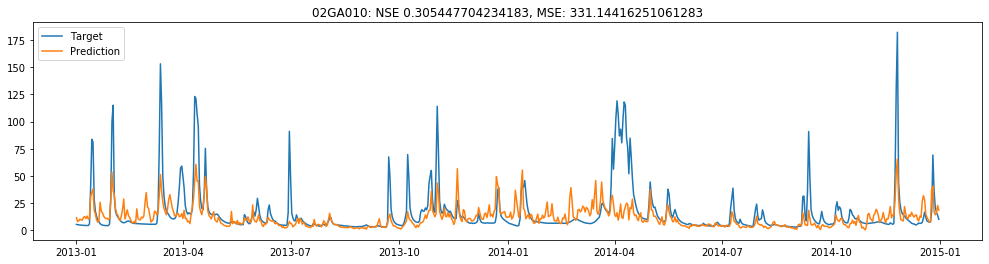

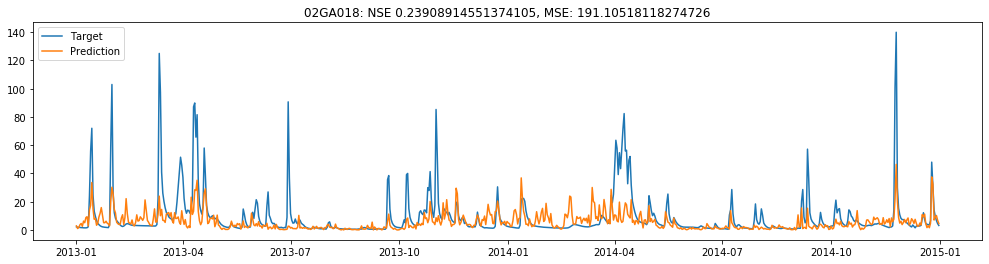

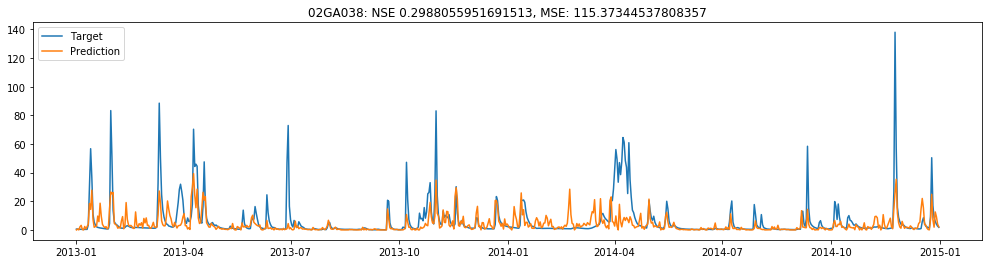

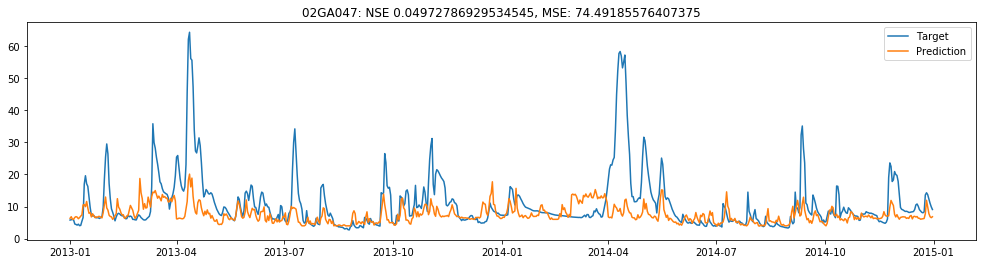

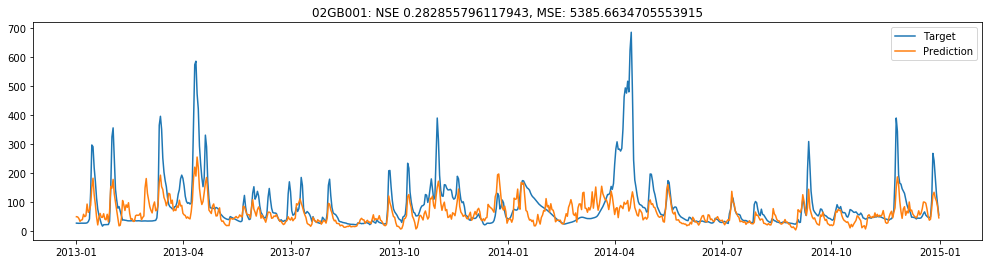

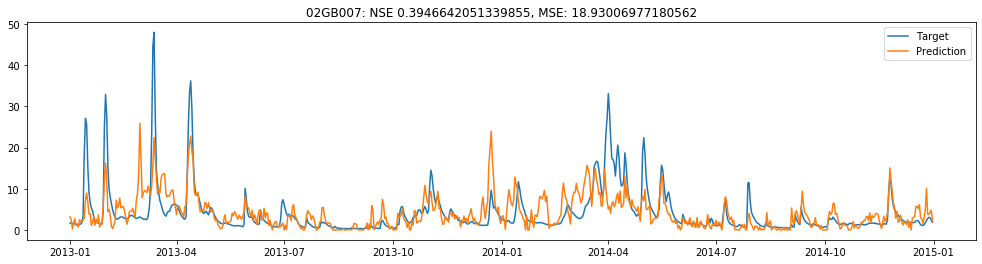

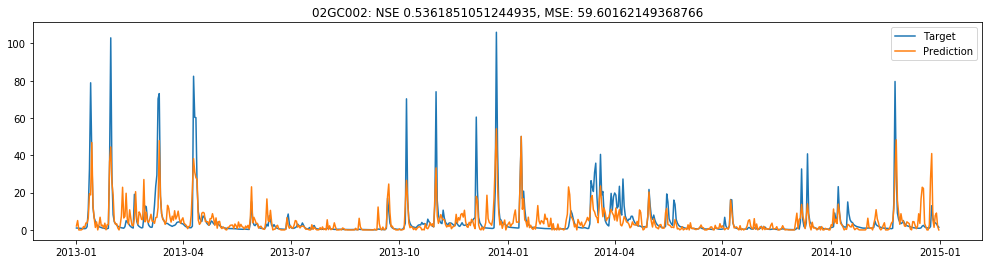

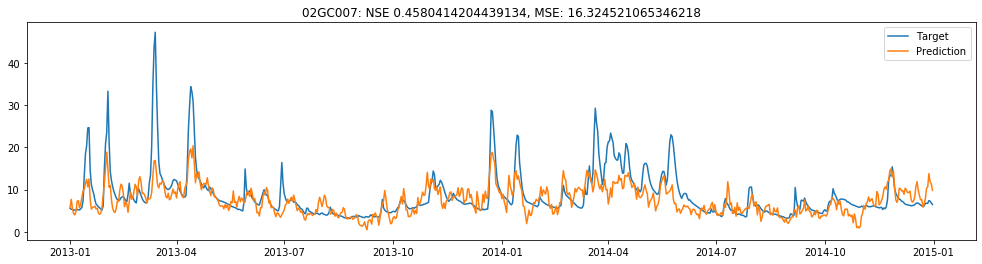

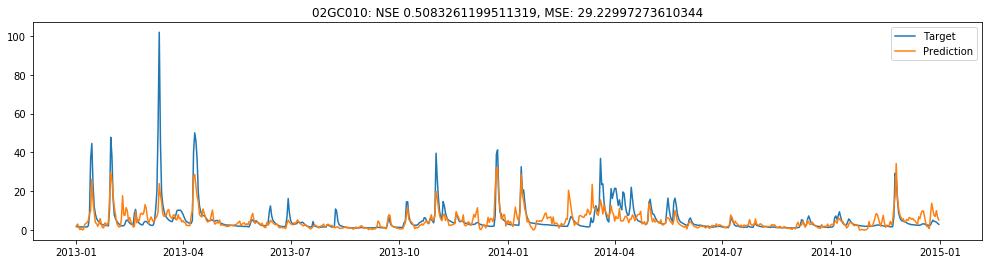

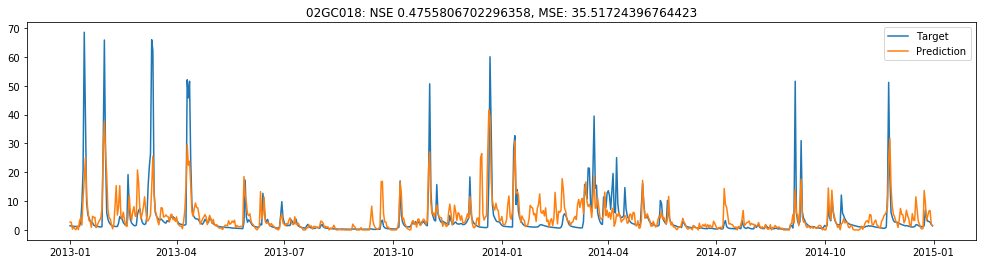

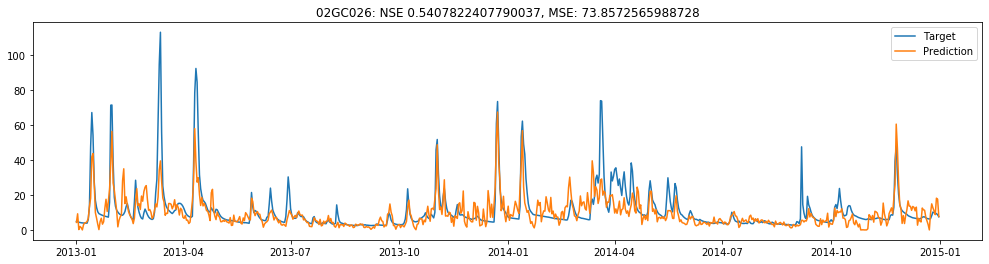

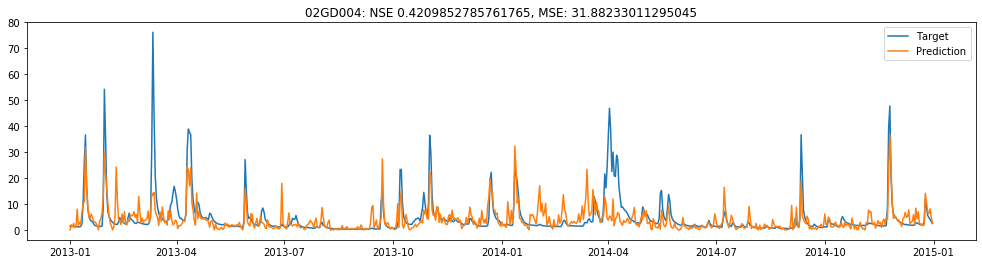

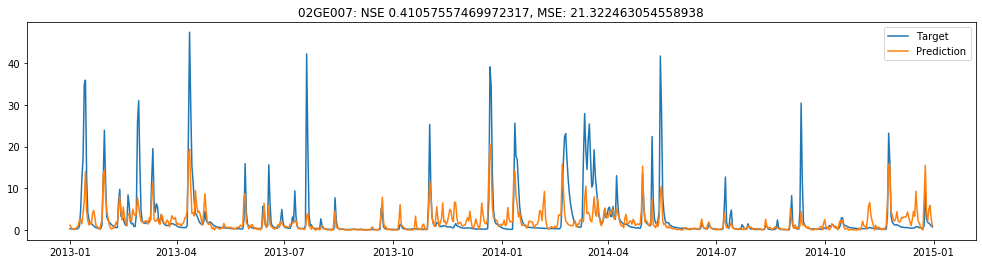

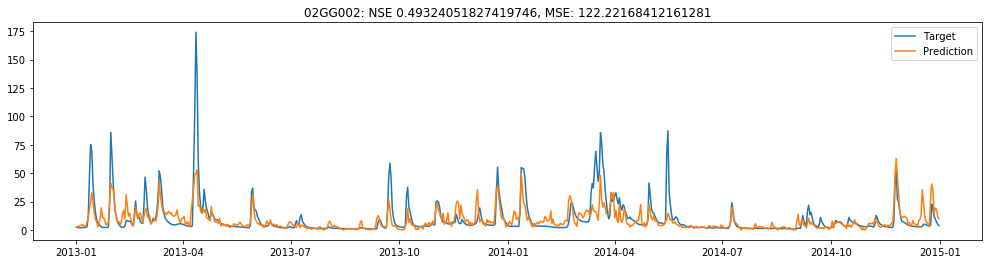

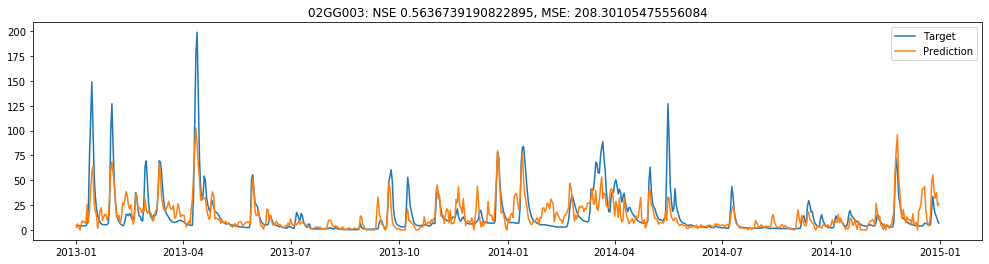

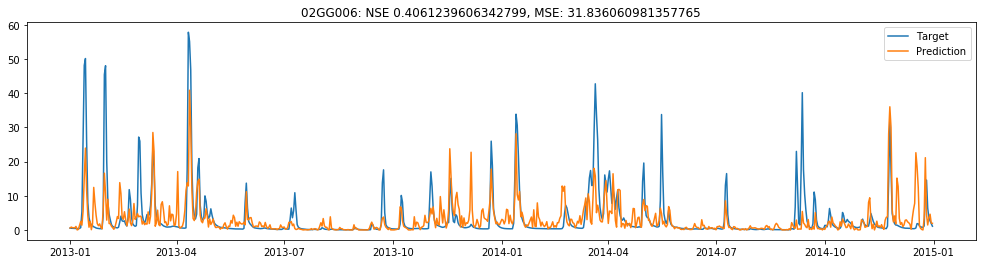

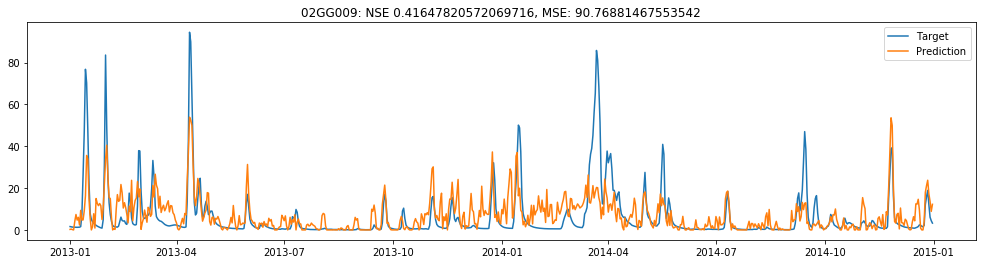

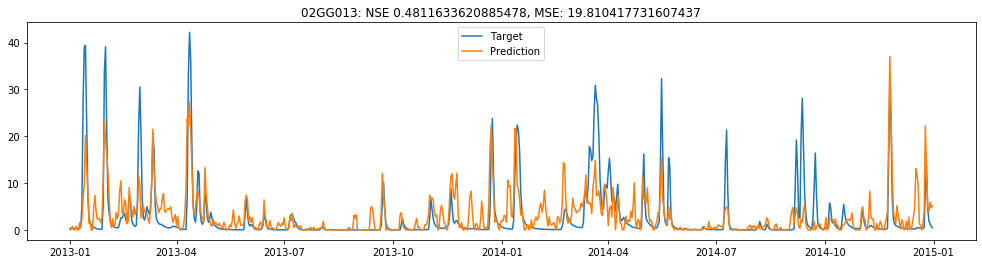

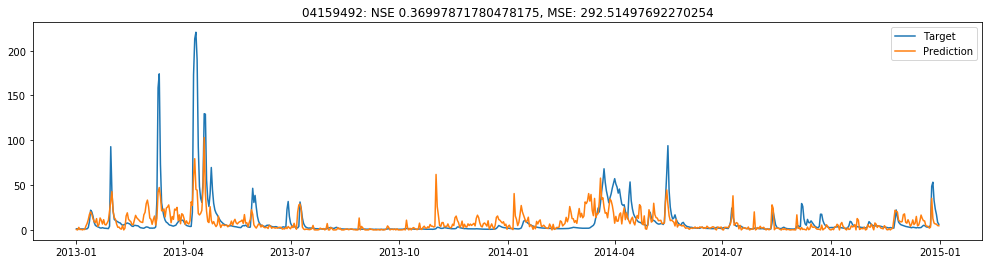

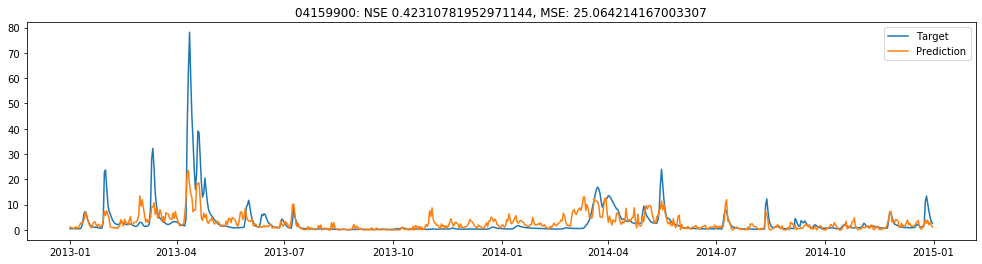

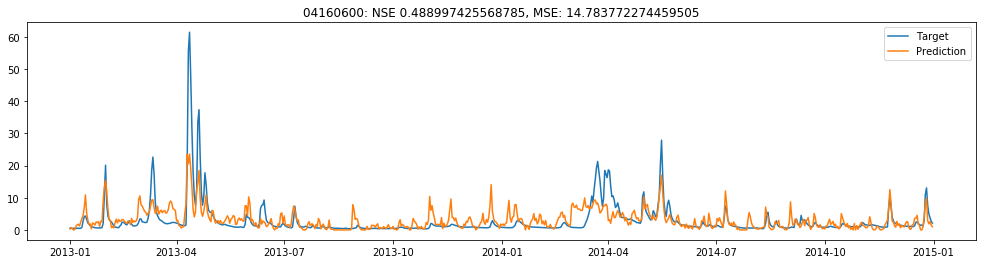

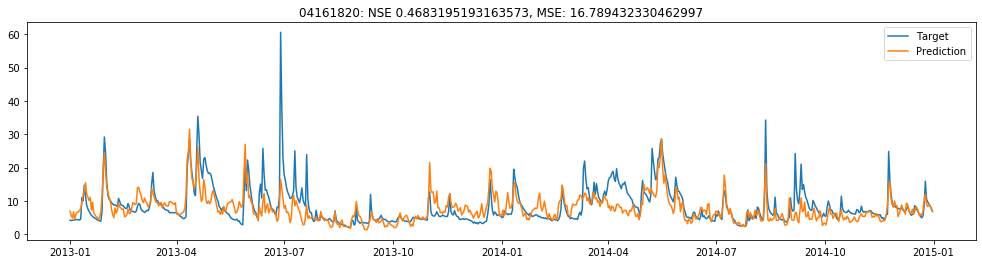

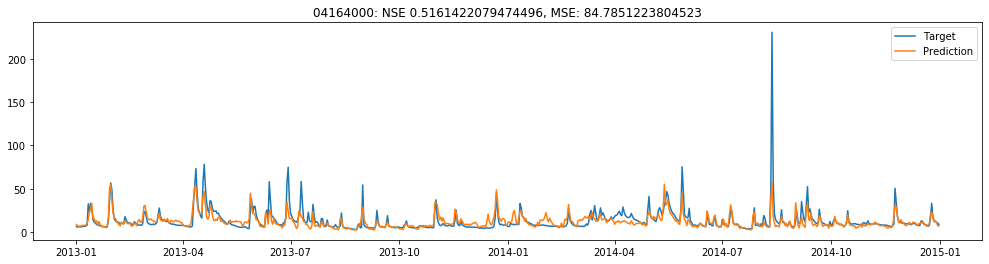

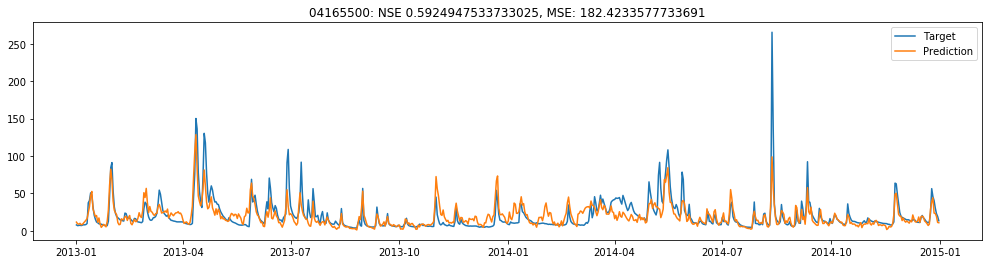

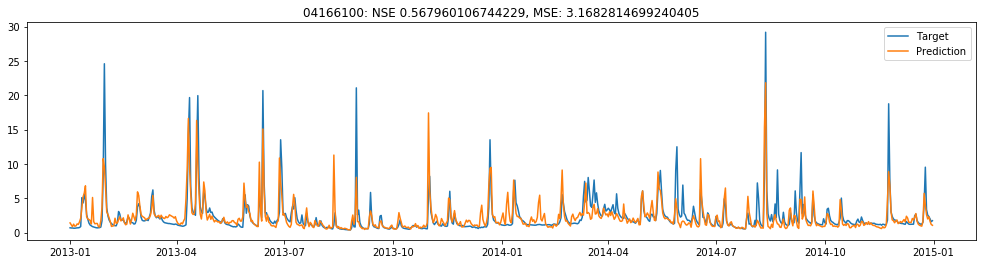

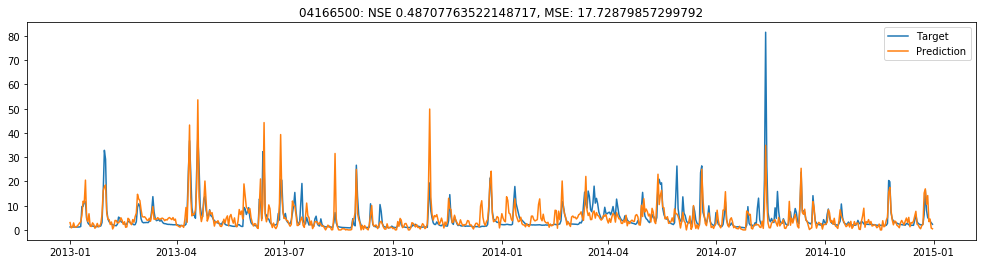

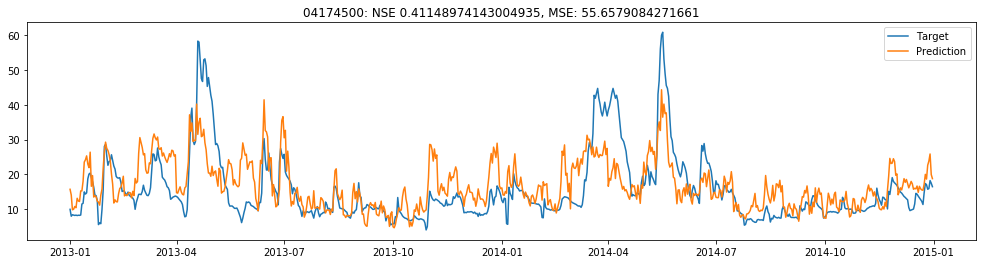

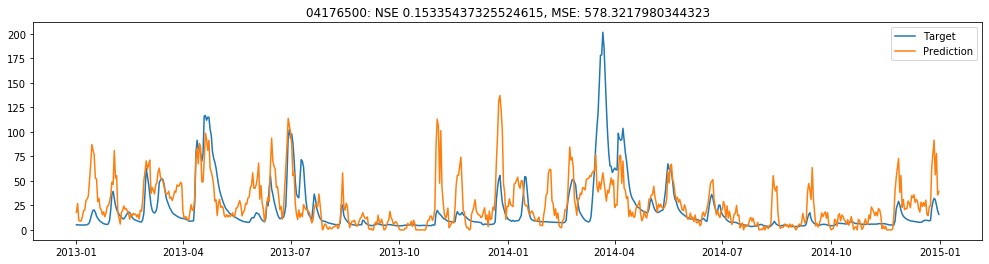

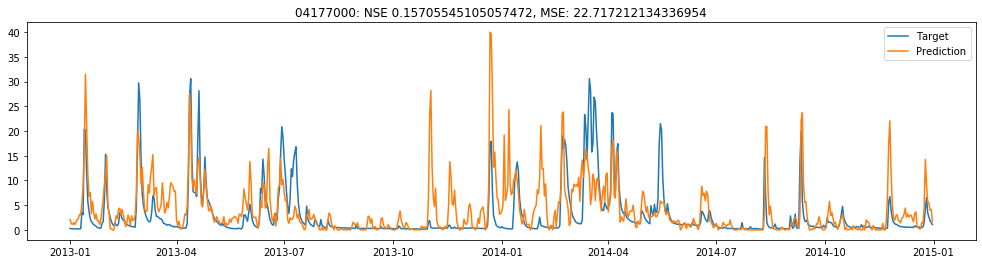

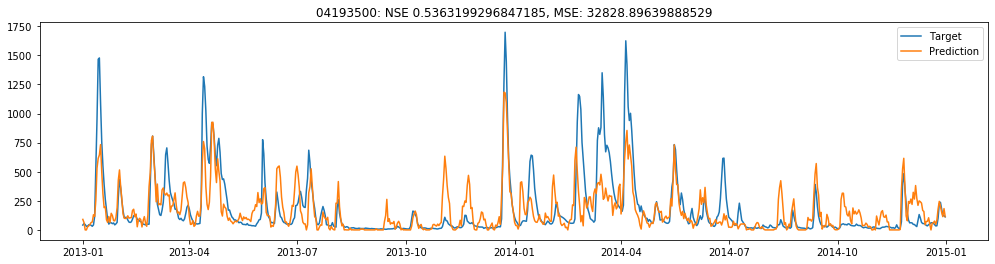

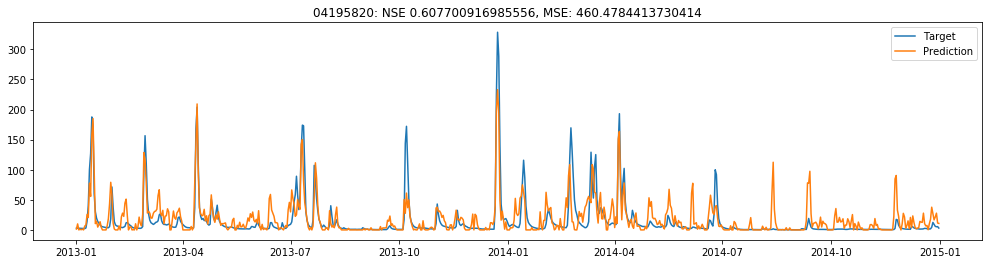

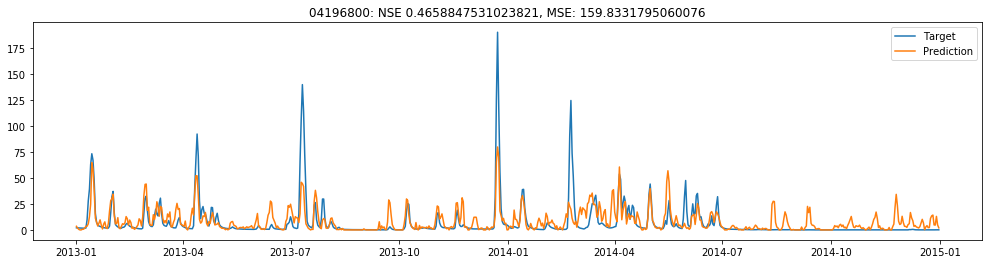

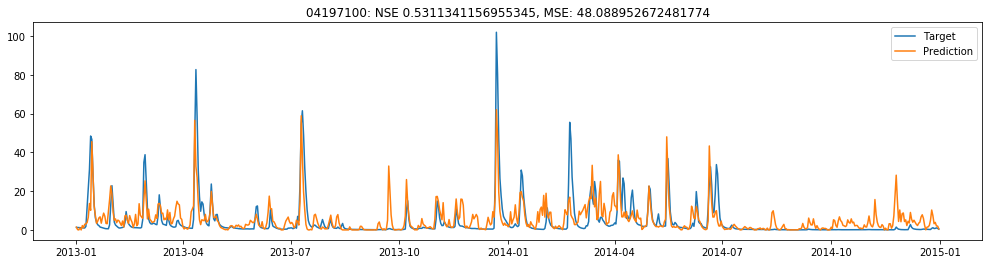

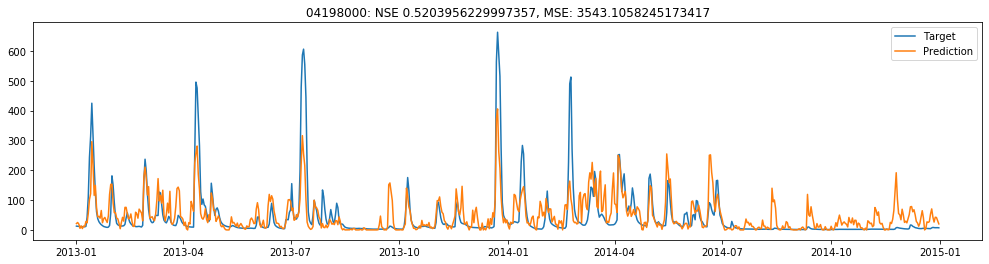

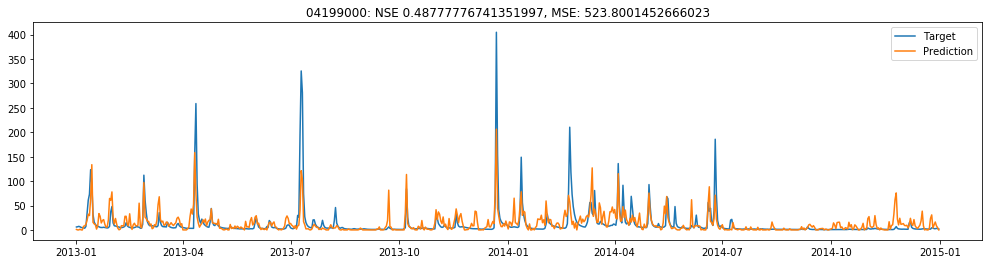

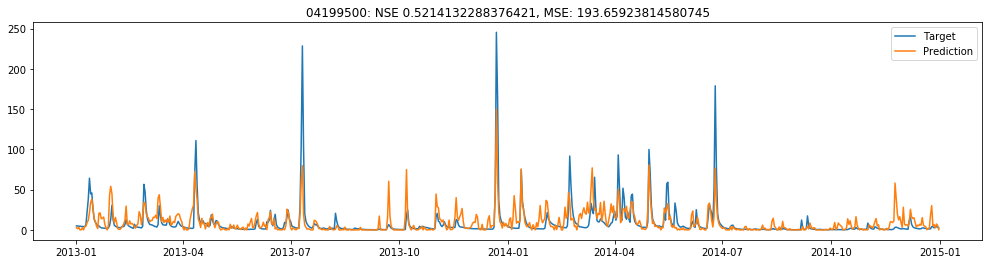

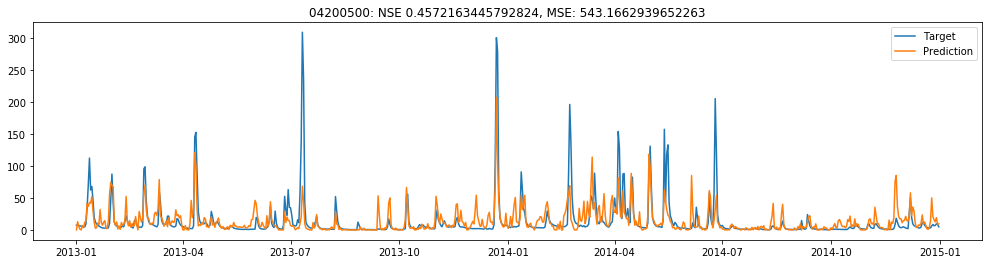

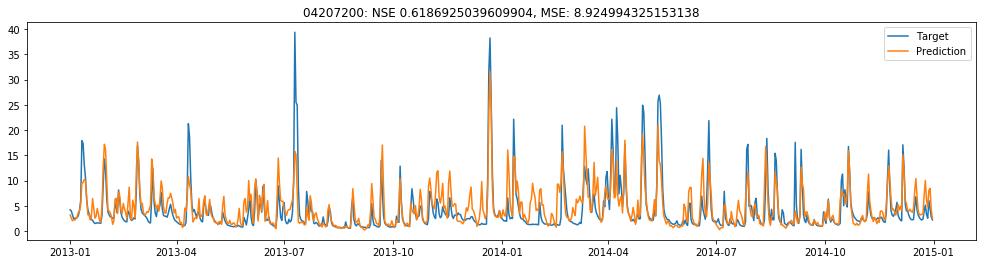

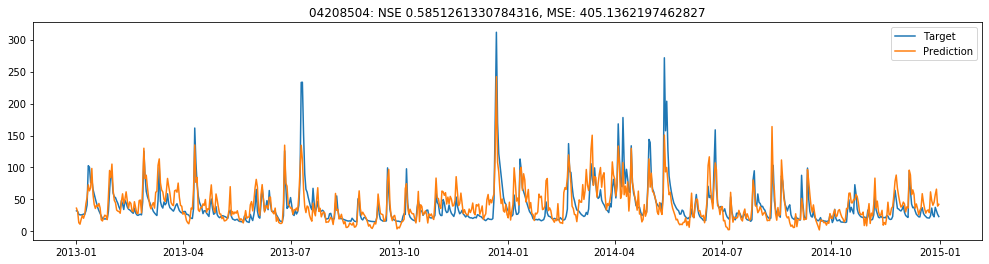

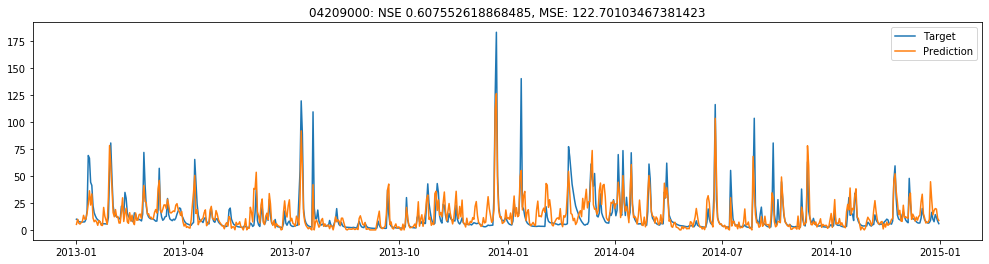

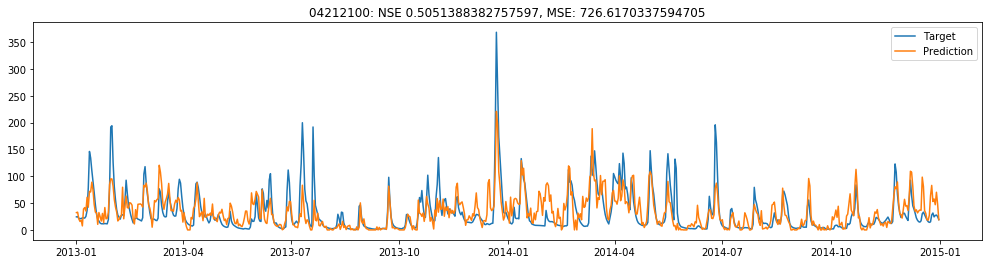

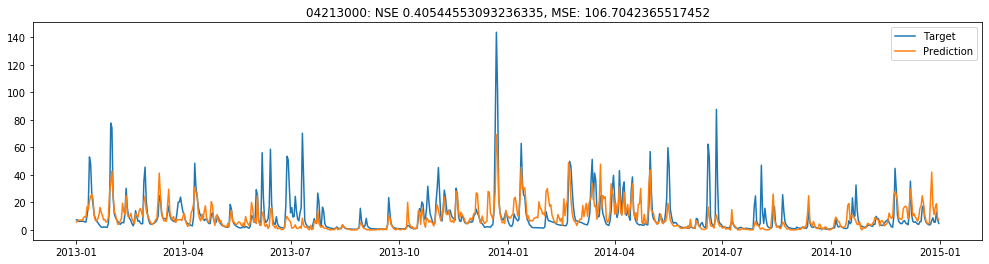

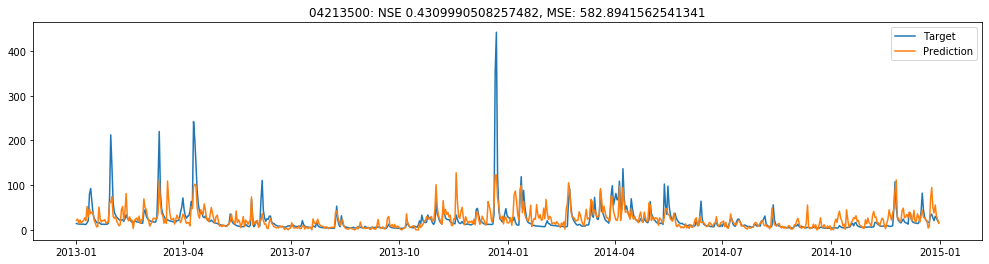

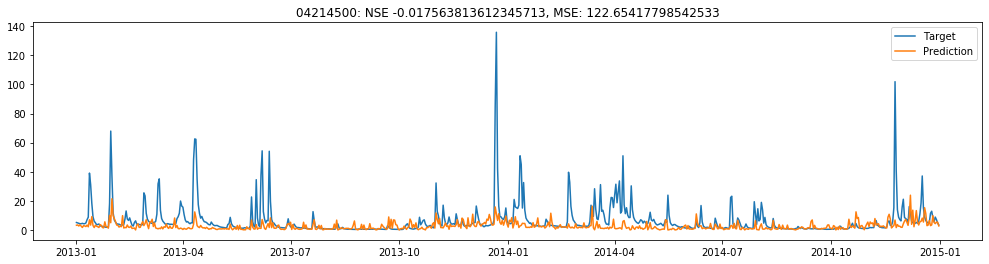

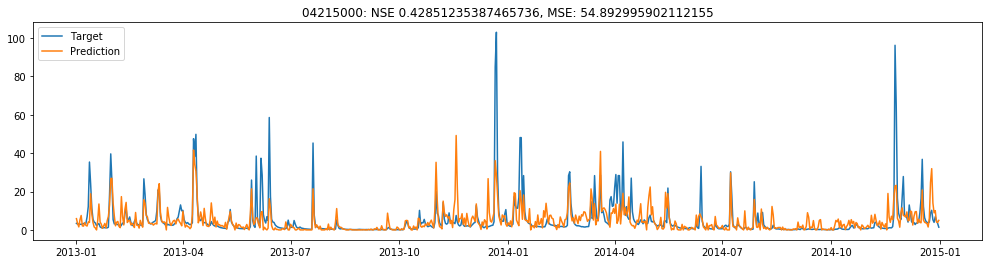

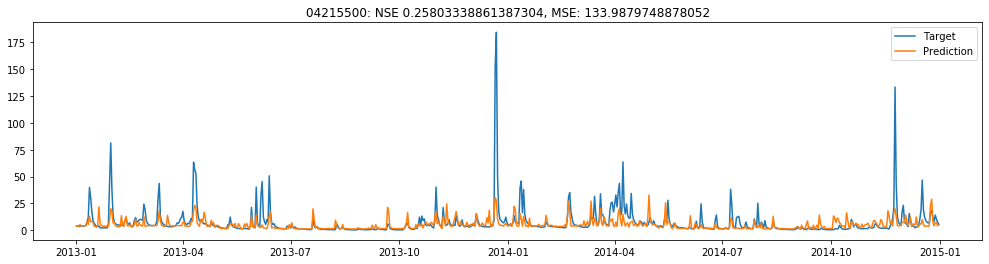

In [5]:
nse_list = []
mse_list = []
for station, predict in predictions.items():
    nse, mse = evaluate.evaluate_daily(station, predict, actuals[station], plot=True)
    nse_list.append(nse)
    mse_list.append(mse)
    
    print(station, '\tNSE:', nse, '\tMSE:', mse, '(clipped to 0)')

print('Median NSE (clipped to 0)', np.median(nse_list), '/ Min', np.min(nse_list), '/ Max', np.max(nse_list))
print('Median MSE (clipped to 0)', np.median(mse_list), '/ Min', np.min(mse_list), '/ Max', np.max(mse_list))

In [6]:
load_data.pickle_results('XGBoost_VIC_aggregateForcings', (predictions, actuals), time_stamp)

'XGBoost_VIC_aggregateForcings_20190706-115444.pkl'

In [7]:
for station, model in models.items():
    load_data.pickle_model('XGBoost_VIC_aggregateForcings', model, station, time_stamp, model_type='sklearn')

Saved model as ../pickle/models/XGBoost_VIC_aggregateForcings_02GA010_20190706-115444.pkl
Saved model as ../pickle/models/XGBoost_VIC_aggregateForcings_02GA018_20190706-115444.pkl
Saved model as ../pickle/models/XGBoost_VIC_aggregateForcings_02GA038_20190706-115444.pkl
Saved model as ../pickle/models/XGBoost_VIC_aggregateForcings_02GA047_20190706-115444.pkl
Saved model as ../pickle/models/XGBoost_VIC_aggregateForcings_02GB001_20190706-115444.pkl
Saved model as ../pickle/models/XGBoost_VIC_aggregateForcings_02GB007_20190706-115444.pkl
Saved model as ../pickle/models/XGBoost_VIC_aggregateForcings_02GC002_20190706-115444.pkl
Saved model as ../pickle/models/XGBoost_VIC_aggregateForcings_02GC007_20190706-115444.pkl
Saved model as ../pickle/models/XGBoost_VIC_aggregateForcings_02GC010_20190706-115444.pkl
Saved model as ../pickle/models/XGBoost_VIC_aggregateForcings_02GC018_20190706-115444.pkl
Saved model as ../pickle/models/XGBoost_VIC_aggregateForcings_02GC026_20190706-115444.pkl
Saved mode